# **Focus of AI Research on Climate Change: A Meta-Analysis**

This notebook presents the analysis pipeline used to generate the results for our study on the focus of AI research in addressing climate change. The analysis is based on the Questions Based Analysis dataset.

**Questions Based Analysis Dataset:** This dataset comprises information on 150 publications from top-tier scientific venues (e.g., Nature, Science, New Scientist) that focus on environmental issues. Each publication is represented by a 26-dimensional vector containing meta-research annotations. These annotations cover aspects such as the research focus, sentiment expressed, use of strong wording, and the developmental stage of the AI methodologies employed.

***To execute this notebook successfully, the dataset must be loaded first. (i.e. as prompted in the next cell)***

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib.transforms import Bbox
from matplotlib.colors import ListedColormap, BoundaryNorm
import io
import base64
import ipywidgets as widgets
from IPython.display import display

# Prompt for the excel input file


In [ ]:
uploader = widgets.FileUpload(
    accept='.xlsx',
    multiple=False
)

display(uploader)

def get_uploaded_df():
    if uploader.value:
        uploaded_file = list(uploader.value.values())[0]
        content = io.BytesIO(uploaded_file['content'])
        df = pd.read_excel(content,sheet_name='Question Based Analysis')
        return df
    else:
        print("No file uploaded yet.")

FileUpload(value={}, accept='.xlsx', description='Upload')

In [ ]:
df = get_uploaded_df()
df = df.drop(0) # Drop the first row with the question text
df = df.rename(columns={'Unnamed: 10': 'Examples of Strong Words'})
df = df[df['Included in analysis'] == 'Yes']

# Objective 1: Optimism and Feasibility of AI in Environmental Solutions


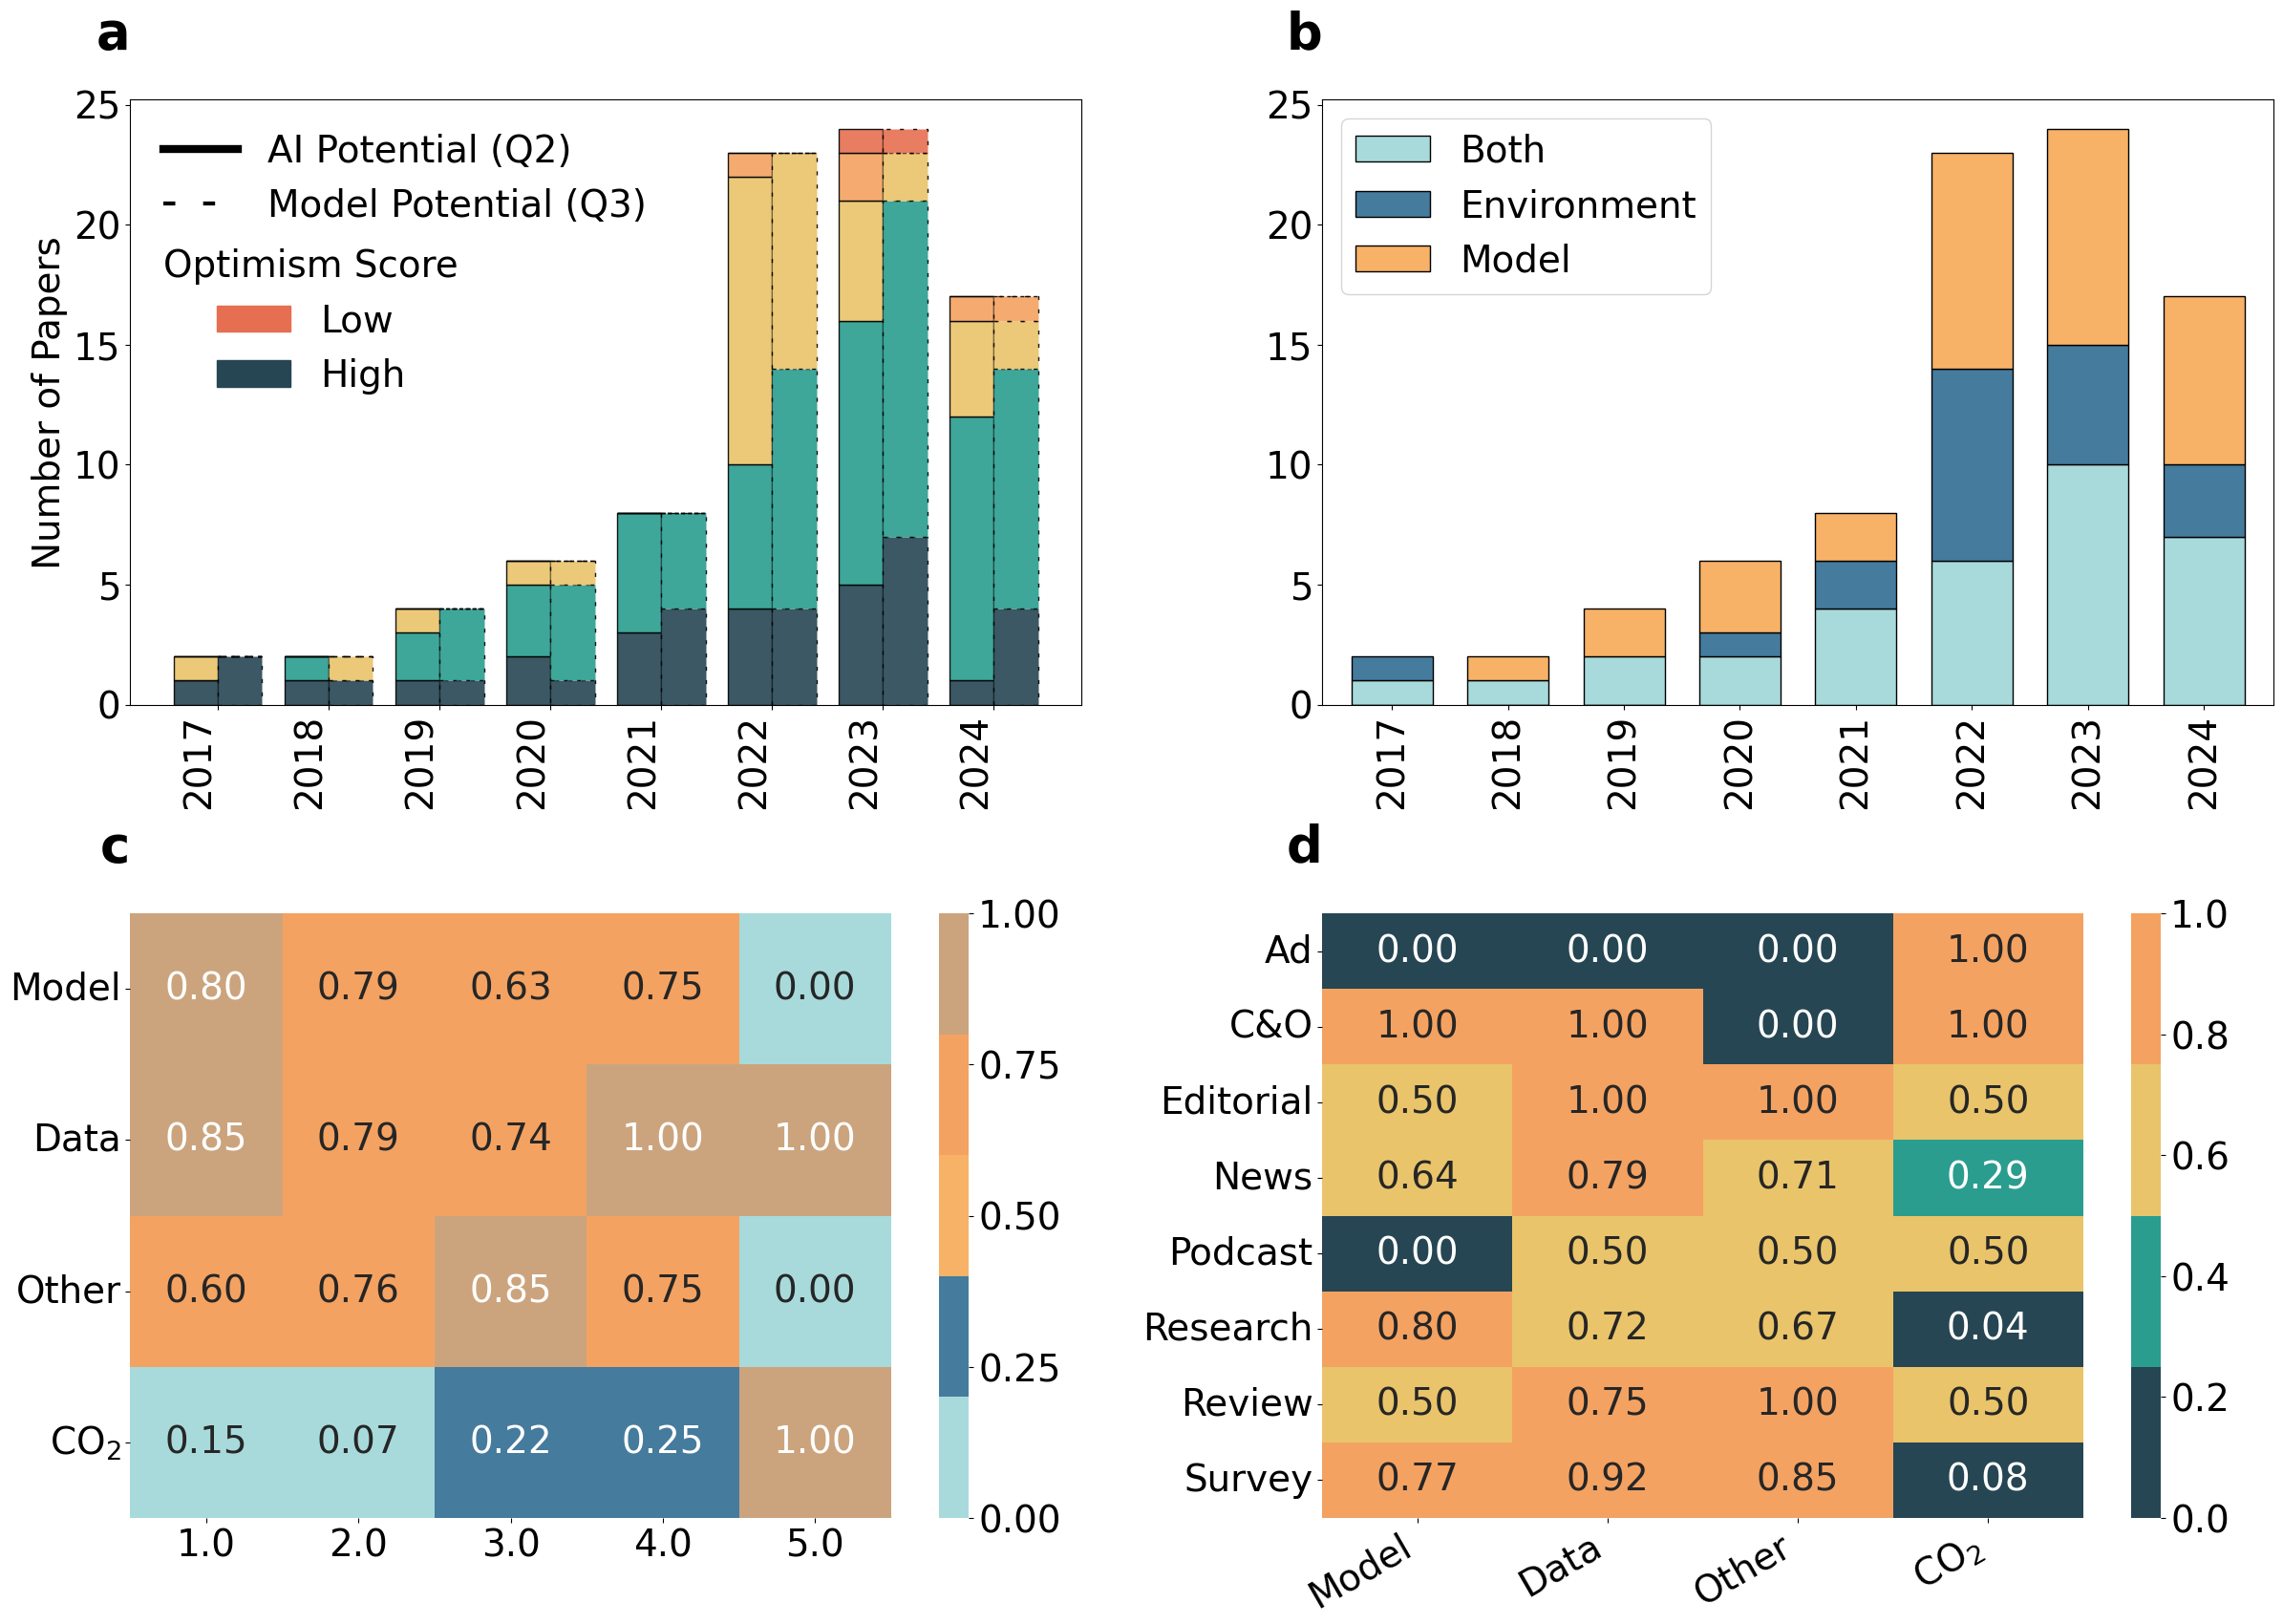

In [ ]:
# --- Load & Prepare Data ---
data_filtered = df.dropna(
    subset=[
        "2. Is the article optimistic or pessimistic about AI’s potential to address climate change?",
        "3. Is the article optimistic or pessimistic about the effectiveness of its specific AI model in addressing climate change?",
        "Year"
    ]
)

sentiment_q1 = pd.to_numeric(data_filtered["2. Is the article optimistic or pessimistic about AI’s potential to address climate change?"], errors="coerce").dropna()
sentiment_q2 = pd.to_numeric(data_filtered["3. Is the article optimistic or pessimistic about the effectiveness of its specific AI model in addressing climate change?"], errors="coerce").dropna()
year_col = pd.to_numeric(data_filtered["Year"], errors="coerce").dropna()

# Create DataFrames for Sentiments
aligned_data_q1 = pd.DataFrame({"Year": year_col, "Sentiment": sentiment_q1, "Question": "AI Potential"})
aligned_data_q2 = pd.DataFrame({"Year": year_col, "Sentiment": sentiment_q2, "Question": "Model Impact"})
aligned_sentiment_data = pd.concat([aligned_data_q1, aligned_data_q2])

# Group by Year, Question, Sentiment
sentiment_year_distribution = (
    aligned_sentiment_data
    .groupby(["Year", "Question", "Sentiment"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Research Focus Over Time
df_focus = data_filtered[["Year", "6. What does the article primarily focus on: AI model development or addressing the environmental issue?"]].dropna()
df_focus.columns = ["Year", "Research Focus"]
focus_counts = df_focus.groupby(["Year", "Research Focus"]).size().unstack(fill_value=0)

# Proportion of Papers Mentioning Limitations per Optimism Level
optimism_col = pd.to_numeric(df["2. Is the article optimistic or pessimistic about AI’s potential to address climate change?"], errors='coerce')
model_limitations_col = df["10. Does the article mention model limitations?"]
data_limitations_col = df["11. Does the article mention data limitations? "]
general_limitations_col = df["12. Does the article mention other limitations? "]
carbon_footprint_col = df["14. Does the article mention the carbon footprint of AI?"]

df_limitations = pd.DataFrame({
    "Optimism": optimism_col,
    "Model Limitations": model_limitations_col.str.strip().str.lower(),
    "Data Limitations": data_limitations_col.str.strip().str.lower(),
    "General Limitations": general_limitations_col.str.strip().str.lower(),
    "Carbon Footprint": carbon_footprint_col.str.strip().str.lower()
}).dropna()

for col in ["Model Limitations", "Data Limitations", "General Limitations", "Carbon Footprint"]:
    df_limitations[col] = df_limitations[col].map({"yes": 1, "no": 0})

limitation_proportions = df_limitations.groupby("Optimism")[["Model Limitations", "Data Limitations", "General Limitations", "Carbon Footprint"]].mean()

# Feasibility Factors by Publication Type
df_feas = df[["18. What type of publication is the article?", "10. Does the article mention model limitations?", "11. Does the article mention data limitations? ", "12. Does the article mention other limitations? ", "14. Does the article mention the carbon footprint of AI?"]].dropna()
df_feas.columns = ["Paper Type", "Model Limitations", "Data Limitations", "General Limitations", "Carbon Footprint"]

for col in ["Model Limitations", "Data Limitations", "General Limitations", "Carbon Footprint"]:
    df_feas[col] = df_feas[col].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})

feasibility_agg = df_feas.groupby("Paper Type")[["Model Limitations", "Data Limitations", "General Limitations", "Carbon Footprint"]].mean()


mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Nimbus Sans', 'DejaVu Sans', 'Liberation Sans']


# --- Create Combined Figure ---
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
font_size = 28
font_size_large = 34


# -------------------
# Top Left: Sentiment Distribution
# -------------------
ax1 = axes[0, 0]
years = sentiment_year_distribution["Year"].unique()
years.sort()
x_positions = np.arange(len(years))
width = 0.4


# Custom color palette from low (negative) to high (positive) sentiment
sentiment_colors = {
    1: "#264653",  # dark muted blue
    2: "#2A9D8F",  # teal
    3: "#E9C46A",  # warm neutral (yellowish)
    4: "#F4A261",  # soft orange
    5: "#E76F51",  # coral/red
}

for i, question in enumerate(["AI Potential", "Model Impact"]):
    subset = sentiment_year_distribution[sentiment_year_distribution["Question"] == question]
    subset = subset.set_index("Year").reindex(years, fill_value=0).reset_index()
    x_offset = x_positions - (width / 2) if question == "AI Potential" else x_positions + (width / 2)
    bottom_values = np.zeros(len(years))

    for sentiment_score in range(1, 6):
        if sentiment_score in subset.columns:
            color = sentiment_colors[sentiment_score]  # use custom colors here
            linestyle = "solid" if question == "AI Potential" else (0, (3, 7))
            ax1.bar(
                x_offset,
                subset[sentiment_score],
                width=width,
                bottom=bottom_values,
                color=color,
                edgecolor="black",
                linestyle=linestyle,
                alpha=0.9,
            )
            bottom_values += subset[sentiment_score]

solid_line = mlines.Line2D([], [], color="black", linewidth=6, linestyle="solid", label="AI Potential (Q2)")
dashed_line = mlines.Line2D([], [], color="black", linewidth=3, linestyle=(0, (3, 7)), label="Model Potential (Q3)")

legend_patches = [
    mpatches.Patch(color=sentiment_colors[5], label="Low"),
    mpatches.Patch(color=sentiment_colors[1], label="High")
]

legend1 = ax1.legend(
    handles=[solid_line, dashed_line],
    fontsize=font_size,
    loc="upper left",
    bbox_to_anchor=(0, 1),
    frameon=False
)

ax1.add_artist(legend1)
legend2 = ax1.legend(
    handles=legend_patches,
    fontsize=font_size,
    title="Optimism Score",
    title_fontsize=font_size,
    loc="upper left",
    bbox_to_anchor=(0, 0.81),
    frameon=False
)

ax1.set_xticks(x_positions)
ax1.set_xticklabels([int(y) if y != 2016 else 2014 for y in years], rotation=90, ha="right", fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.set_ylabel("Number of Papers",fontsize=font_size )


# -------------------
# Top Right: Research Focus Over Time
# -------------------

focus_colors = [
    "#A8DADC",  # light aqua
    "#457B9D",  # muted denim blue
    "#F7B267",  # soft peach
    "#F4A261",  # warm orange
    "#E76F51",  # coral red
]


ax2 = axes[0, 1]

focus_counts.plot(
    kind="bar",
    stacked=True,
    ax=ax2,
    edgecolor="black",
    width=0.7,
    color=focus_colors[:len(focus_counts.columns)]
)

ax2.tick_params(labelsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("")

ax2.set_xticklabels(
    [int(float(label.get_text())) if int(float(label.get_text())) != 2016 else 2014 for label in ax2.get_xticklabels()],
    fontsize=font_size
)

# # -------------------
# Bottom Left: Limitations vs. Optimism
# -------------------

limitation_colors = [
    "#A8DADC",  # soft aqua
    "#457B9D",  # muted blue
    "#F7B267",  # light peach
    "#F4A261",  # warm orange
    "#CBA47E"   # sandy brown
]
limitations_cmap = ListedColormap(limitation_colors)
bounds = [0, 1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, ncolors=limitations_cmap.N)



ax3 = axes[1, 0]

heatmap = sns.heatmap(
    limitation_proportions.T,
    annot=True,
    ax=ax3,
    cmap=limitations_cmap,
    cbar=True,
    vmin=0,
    vmax=1,
    fmt=".2f",
    annot_kws={"fontsize": font_size}
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=font_size)
ax3.tick_params(labelsize=font_size)
ax3.set_yticklabels(['Model', 'Data', 'Other', "CO$_2$"], rotation=0, ha='right', fontsize=font_size)
ax3.set_xlabel("")
ax3.set_ylabel("")


# -------------------
# Bottom Right: Feasibility by Publication Type
# -------------------
ax4 = axes[1, 1]
palm_cmap = sns.color_palette(["#264653", "#2A9D8F", "#E9C46A", "#F4A261"], as_cmap=True)

heatmap = sns.heatmap(
    feasibility_agg,
    ax=ax4,
    cmap=palm_cmap,
    annot=True,
    fmt=".2f",
    cbar=True,
    annot_kws={"fontsize": font_size}
)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)
ax4.tick_params(labelsize=font_size)
ax4.set_xticklabels(['Model', 'Data', 'Other', "CO$_2$"], rotation=30, ha="right", fontsize=font_size)
ax4.set_yticklabels(
    ['Ad', 'C&O', 'Editorial', 'News', 'Podcast', 'Research', 'Review', 'Survey'],
    rotation=0, ha='right', fontsize=font_size
)

ax4.set_xlabel("")
ax4.set_ylabel("")
pos = ax4.get_position()
ax4.set_position(Bbox.from_bounds(pos.x0 - 0.02, pos.y0, pos.width, pos.height))
labels = ["a", "b", "c", "d"]
positions = [(0, 1.15), (0, 1.15), (0, 1.15), (0, 1.15)]
for ax, label, (x, y) in zip(axes.flat, labels, positions):
    ax.text(x, y, label, transform=ax.transAxes,
            fontsize=font_size + 10, fontweight='bold', va='top', ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Figure1.pdf', format='pdf', bbox_inches='tight')
plt.show()

### **Commentary on the "Research Focus Over Time" Plot**
#### **Overview**
The **"Research Focus Over Time"** plot visualizes how research in AI and climate change has been distributed between:
1. **Development of AI Models** (cool-toned color)
2. **Addressing Environmental Issues** (warm-toned color)
3. **Both aspects combined** (if applicable, neutral color)

#### **Observations & Trends**
✅ **Temporal Shifts in Focus**  
- Some years show a **dominance of AI model development**, while others indicate a **higher focus on environmental applications**.  
- This may suggest a shift in research priorities over time.

✅ **Parallel Growth or Trade-offs?**  
- If the **two categories grow simultaneously**, it suggests an increasing overall interest in AI for climate solutions.  
- If one category **decreases while the other increases**, this could indicate a shift in research funding, priorities, or methodologies.

✅ **Emergence of "Both" Category (if present)**  
- If a **"Both"** category exists, it suggests that more papers have started **balancing AI development with environmental concerns**, rather than focusing on one exclusively.

✅ **Fluctuations in Interest**  
- Spikes in one category could correspond to major conferences, policy changes, or breakthroughs in AI.  
- Dips may reflect shifts in funding or global research priorities.

✅ **Recent Trends Matter**  
- The **last few years** in the dataset are crucial. Are AI researchers becoming more environmentally aware?  
- Is AI development still growing, or is research becoming more application-driven?

#### **Possible Interpretation**
- If research is increasingly focusing on **addressing environmental issues**, it may indicate **growing awareness of sustainability challenges** in AI.
- If the focus on **AI model development remains dominant**, it suggests a **technology-first approach**, where solving climate challenges may still be secondary.

#### **Final Thoughts**
This plot **contextualizes AI research priorities** over time, showing whether the field is evolving toward sustainability or remains focused on advancing AI capabilities. **Further analysis could compare these trends with external factors like funding, policy changes, and real-world climate impact assessments.** 🚀

---


### **Commentary on the First Heatmap: "Proportion of Papers Mentioning Limitations per Optimism Level"**

#### **Overview**
This heatmap visualizes how often different **limitations** (model limitations, data limitations, general limitations, and carbon footprint) are mentioned in research papers, grouped by their **optimism level** regarding AI’s potential to address climate change.

- The **columns** represent **optimism scores** (1 = **most optimistic**, 5 = **most pessimistic**).  
- The **rows** represent different types of limitations discussed in the papers.  
- The **color intensity** (YlGnBu colormap) reflects the **proportion of papers mentioning each limitation**, with **darker blue indicating a higher proportion.**

---

### **Key Observations & Trends**
✅ **Pessimistic Papers Tend to Acknowledge More Limitations**  
- If the **rightmost columns (higher pessimism scores) have darker shades**, this suggests that **papers with a pessimistic outlook** on AI’s role in climate change tend to acknowledge more limitations.  
- This could indicate that researchers who are more critical of AI **are also more aware of its technical, data, and environmental shortcomings**.

✅ **Optimistic Papers May Downplay Limitations**  
- If the **leftmost columns (lower pessimism scores) have lighter shades**, it suggests that **highly optimistic papers tend to mention fewer limitations**.
- This could reflect a **bias towards technological optimism**, where researchers see AI as a solution rather than critically evaluating its weaknesses.

✅ **Variation Across Different Limitation Types**  
- **Model Limitations**: If frequently mentioned across optimism levels, it suggests that issues related to AI models (e.g., accuracy, generalizability) are widely recognized.  
- **Data Limitations**: If underrepresented in optimistic papers but prevalent in pessimistic ones, it could indicate that **data challenges are overlooked by those who believe in AI’s potential**.  
- **Carbon Footprint**: If primarily acknowledged in pessimistic papers, it suggests that **environmental concerns about AI are more prominent among skeptics**.

✅ **Balanced Recognition of Limitations?**  
- If the heatmap **does not show extreme contrast** (i.e., all optimism levels acknowledge limitations to some extent), this could mean that **AI researchers generally recognize both its strengths and weaknesses, regardless of their stance on its climate potential.**

---

### **Possible Interpretations**
📌 **If pessimistic papers mention limitations more frequently**, it suggests a **realistic or skeptical view of AI’s effectiveness**, emphasizing its drawbacks.  
📌 **If optimistic papers consistently mention fewer limitations**, it may indicate a **technological optimism bias**, where researchers focus on AI’s potential solutions rather than its challenges.  
📌 **If all sentiment groups discuss limitations equally**, this suggests a **mature and balanced perspective in AI research**, where both strengths and weaknesses are acknowledged.  

---

### **Next Steps for Deeper Analysis**
🔹 **Compare trends over time**—Do researchers today acknowledge more limitations than before?  
🔹 **Analyze limitation types separately**—Are **data limitations** a bigger concern than **carbon footprint issues**?  
🔹 **Correlate with research focus**—Do **papers focusing on AI development** mention fewer limitations than those addressing climate issues?  

---

### **Final Thoughts**
This heatmap **provides insight into how the perception of AI’s potential influences how critically researchers evaluate its limitations.**  
Would you like to **overlay additional data (e.g., funding sources, institution type) to explore external influences** on optimism and limitation recognition? 🚀

# Objective 2: AI’s Role in Environmental Problem-Solving

## Sankey Diagram: Novelty Level - Task Type - Environmental Issue - Deployment Stage


In [ ]:
# Clean and prepare data for Objective 2

df['16. How novel is the AI technology used in the article? '] = df['16. How novel is the AI technology used in the article? '].fillna('N/A').astype(str)
df = df.explode('16. How novel is the AI technology used in the article? ').reset_index(drop=True)

df['9. Which aspect of environmental problem-solving does the article focus on? '] = df['9. Which aspect of environmental problem-solving does the article focus on? '].fillna('Unknown').astype(str)
df['8. Which environmental or climate issue does the article address?'] = df['8. Which environmental or climate issue does the article address?'].fillna('Unknown').astype(str)
df['7. At what stage of development is the AI technology?'] = df['7. At what stage of development is the AI technology?'].fillna('Unknown').astype(str)

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  # Convert to numeric
df = df.dropna(subset=['Year'])  # Drop rows where Year is missing

df['tech']  = df['16. How novel is the AI technology used in the article? ']
df['cat']   = df['9. Which aspect of environmental problem-solving does the article focus on? ']
df['env']   = df['8. Which environmental or climate issue does the article address?']
df['stage'] = df['7. At what stage of development is the AI technology?']

tech_nodes  = df['tech'].unique().tolist()
cat_nodes   = df['cat'].unique().tolist()
env_nodes   = df['env'].unique().tolist()
stage_nodes = df['stage'].unique().tolist()

tech_keys  = [('Novelty Level', v) for v in tech_nodes]
cat_keys   = [('Task Type', v) for v in cat_nodes]
env_keys   = [('Environmental Issue', v) for v in env_nodes]
stage_keys = [('Development Stage', v) for v in stage_nodes]

all_node_keys = tech_keys + cat_keys + env_keys + stage_keys
node_labels = [key[1] for key in all_node_keys]
node_indices = { key: i for i, key in enumerate(all_node_keys) }

min_year, max_year = df['Year'].min(), df['Year'].max()

cmap = cm.get_cmap("plasma")
norm = mcolors.Normalize(vmin=min_year, vmax=max_year)
year_to_color = {year: mcolors.to_hex(cmap(norm(year))) for year in df['Year'].unique()}

# Create links and track node-year mapping
links = []
node_years = {}  # Store latest year for each node

# Step 1: Technology → Task Type
tech_to_cat = df.groupby(['tech', 'cat', 'Year']).size().reset_index(name='count')
for _, row in tech_to_cat.iterrows():
    source_key = ('Novelty Level', row['tech'])
    target_key = ('Task Type', row['cat'])
    year = row['Year']

    node_years[source_key] = max(node_years.get(source_key, min_year), year)
    node_years[target_key] = max(node_years.get(target_key, min_year), year)

    links.append({
        'source': node_indices[source_key],
        'target': node_indices[target_key],
        'value': row['count'],
        'year': year
    })

# Step 2: Task Type → Environmental Issue
cat_to_env = df.groupby(['cat', 'env', 'Year']).size().reset_index(name='count')
for _, row in cat_to_env.iterrows():
    source_key = ('Task Type', row['cat'])
    target_key = ('Environmental Issue', row['env'])
    year = row['Year']

    node_years[source_key] = max(node_years.get(source_key, min_year), year)
    node_years[target_key] = max(node_years.get(target_key, min_year), year)

    links.append({
        'source': node_indices[source_key],
        'target': node_indices[target_key],
        'value': row['count'],
        'year': year
    })

# Step 3: Environmental Issue → Stage
env_to_stage = df.groupby(['env', 'stage', 'Year']).size().reset_index(name='count')
for _, row in env_to_stage.iterrows():
    source_key = ('Environmental Issue', row['env'])
    target_key = ('Development Stage', row['stage'])
    year = row['Year']

    node_years[source_key] = max(node_years.get(source_key, min_year), year)
    node_years[target_key] = max(node_years.get(target_key, min_year), year)

    links.append({
        'source': node_indices[source_key],
        'target': node_indices[target_key],
        'value': row['count'],
        'year': year
    })

# Assign node colors based on latest year
node_colors = [year_to_color.get(node_years.get(key, min_year), "#bbbbbb") for key in all_node_keys]

def to_rgba_string(hex_color, alpha=0.4):
    """Convert hex color to valid rgba string."""
    r, g, b = mcolors.hex2color(hex_color)  # Convert hex to RGB
    return f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})"

link_colors = [to_rgba_string(year_to_color.get(link['year'], "#bbbbbb"), alpha=0.4) for link in links]

column_x_positions = {
    "Novelty Level": 0.0,
    "Task Type": 0.15,
    "Environmental Issue": 0.5,
    "Development Stage": 0.95
}

node_x_positions = [column_x_positions[key[0]] for key in all_node_keys]
column_y_counters = defaultdict(int)
column_y_totals = defaultdict(int)

for key in all_node_keys:
    column_y_totals[key[0]] += 1

node_y_positions = []
for key in all_node_keys:
    col = key[0]
    i = column_y_counters[col]
    total = column_y_totals[col]
    y_pos = (i + 1) / (total + 1)  # space evenly in [0, 1]

    node_y_positions.append(y_pos)
    column_y_counters[col] += 1

fig = go.Figure(go.Sankey(
    arrangement="fixed",
    node=dict(
        pad=25,
        thickness=10,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors,
        x=node_x_positions,
        y=node_y_positions
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
        color=link_colors
    )
))

annotations = [
    dict(x=-0.05, y=1.2, xref="paper", yref="paper", text="Novelty<br>Level", showarrow=False, font=dict(size=20)),
    dict(x=0.13, y=1.2, xref="paper", yref="paper", text="Task<br>Type", showarrow=False, font=dict(size=20)),
    dict(x=0.52, y=1.2, xref="paper", yref="paper", text="Environmental<br>Issue", showarrow=False, font=dict(size=20)),
    dict(x=1.01, y=1.2, xref="paper", yref="paper", text="Development<br>Stage", showarrow=False, font=dict(size=20))
]


fig.update_layout(annotations=annotations)


fig_cmap, ax = plt.subplots(figsize=(8, 1))
gradient = np.linspace(0, 1, 256).reshape(1, -1)
ax.imshow(gradient, aspect="auto", cmap="plasma")
ax.set_xticks([0, 128, 255])
ax.set_xticklabels([int(min_year), int((min_year + max_year) // 2), int(max_year)], fontsize=62)  # Show year labels
ax.set_yticks([])
ax.set_title("Color Mapping by Year", fontsize=62)
buf = io.BytesIO()
fig_cmap.savefig(buf, format="png", bbox_inches="tight")
plt.close(fig_cmap)

buf.seek(0)
encoded_image = base64.b64encode(buf.read()).decode("utf-8")
image_uri = "data:image/png;base64," + encoded_image

fig.add_layout_image(
    dict(
        source=image_uri,
        x=0.5, y=-0.03,  # Position below the Sankey diagram
        xref="paper", yref="paper",
        sizex=1, sizey=0.1,  # Adjust size
        xanchor="center", yanchor="top",
        layer="below"
    )
)

fig.show()


/tmp/ipython-input-12-261748529.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


### **Description of the Sankey Diagram: AI Technology and Environmental Solutions Over Time**

#### **Overview**
This **Sankey diagram** visually represents the **flow of AI technologies** from their **type** to their **application** in addressing environmental challenges. The nodes in the diagram represent:
1. **AI Technologies (Technology Level)**
2. **Their Categorization (Task Type)**
3. **The Environmental Issues they address**
4. **Their Stage of Development**

The **connections (links)** between nodes indicate **how many research cases exist** for each transition, with **thicker links** representing more frequently observed connections.

Unlike traditional Sankey diagrams, this one includes **time-based coloring**, where:
- **Nodes are colored based on their average year of occurrence**, rather than just the latest year.
- **Links retain their original year association**, helping visualize how AI developments flow across different research areas over time.

---

### **Key Insights from the Diagram**
#### **1️⃣ AI Technology Trends Over Time**
- Different **AI technologies (e.g., Machine Learning, Deep Learning, NLP)** are connected to various **task types**, showing how different techniques are applied in solving environmental issues.
- If **some technologies have a darker or more recent color**, it suggests that they have gained popularity in recent years.
- Conversely, **lighter-colored technologies** may indicate older AI approaches that were more commonly used in past research.

#### **2️⃣ How AI Tasks Are Categorized**
- The second column (**Task Type**) illustrates how AI methods are categorized.  
- If some categories are **more dominant or highly connected**, it suggests that **certain AI approaches are more favored** in climate-related research.
- **Example:** If "Prediction" and "Optimization" receive **thicker flows** from AI technologies, it suggests that AI is mainly used for **forecasting climate trends or optimizing resource use.**

#### **3️⃣ AI's Role in Addressing Environmental Issues**
- The third column (**Environmental Issue**) highlights which environmental challenges AI is most applied to.
- If a specific issue (e.g., **climate modeling, energy efficiency, pollution control**) has **thicker flows**, it suggests **a strong research focus on that topic.**
- If environmental issues have **diverse connections** to task types, it suggests that AI is used in **multiple ways** to tackle them.

#### **4️⃣ The Stage of AI Development**
- The final column (**Stage**) reflects whether the AI technologies **are still in development or being deployed in real-world applications.**
- If most research remains in **“Proof of Concept” or “Pilot” stages**, it indicates that AI is still in **early research phases** for many environmental applications.
- If **“Deployed” cases appear with strong flows**, it means AI has moved into **real-world implementation**.

---

### **Time-Based Coloring: Tracking Evolution Over the Years**
One of the most important aspects of this visualization is the **time-based coloring** of nodes:
- **Darker (more recent) colors** indicate **newer developments** in AI.
- **Lighter (older) colors** suggest **earlier research trends**.

By following the gradient of colors across different columns, we can see:
- **Are certain AI techniques newer than others?**
- **Are some environmental applications more recent than others?**
- **Is AI still mostly experimental, or is it reaching practical implementation?**

---

### **Potential Findings from the Data**
1️⃣ **Some AI methods might be shifting over time.**  
   - If Machine Learning was historically dominant but newer methods (e.g., Deep Learning, Reinforcement Learning) are appearing **in more recent years**, it suggests an **evolution of AI in environmental research**.

2️⃣ **Certain environmental applications might be receiving more AI attention recently.**  
   - If “Energy Efficiency” or “Climate Modeling” has **recent colors**, it suggests growing AI adoption in those areas.

3️⃣ **Many AI applications might still be in early development stages.**  
   - If **most AI technologies connect to Proof-of-Concept or Pilot stages**, it indicates that AI is **still being tested in academic or experimental settings** rather than being widely deployed.

4️⃣ **Older AI research might have been more focused on specific tasks.**  
   - If older technologies were mostly used for **“Prediction”**, but newer ones are branching into **“Optimization” and “Decision Support”**, it suggests an **expansion of AI’s role in environmental solutions.**

---

### **Final Thoughts: What This Diagram Tells Us**
📌 **This Sankey diagram provides a time-aware analysis of how AI is applied to environmental issues, from technology type to real-world implementation.**  
📌 **It highlights whether AI applications are still experimental or are transitioning toward practical use.**  
📌 **By analyzing node colors and link thickness, we can observe shifts in AI research trends over time.**  

---


# Objective 3: Trends in AI and Environmental Discourse


Here are some **comments and insights** on the **stacked bar chart of Q8 (Environmental Issue) vs. Q18 (Was this previously addressed?)**:

---

## 📊 **Interpretation & Insights**
### ✅ **1. General Distribution of Responses**
- The chart shows the **proportion of papers** that indicate whether an environmental issue **was previously addressed using another method**.
- Each **bar represents an environmental issue** (Flooding, Biodiversity, etc.), with **Yes, No, and NA responses stacked**.

### 🟢 **2. High "Yes" Proportions (Green)**
- If certain environmental issues have a **large green section**, this suggests that these issues have **been addressed before** using other methods.
- Example: If "Flooding" has a high **Yes** proportion, it means many papers acknowledge existing solutions.

### 🔴 **3. High "No" Proportions (Red)**
- A high **red proportion** indicates **papers state that the issue hasn’t been solved before**.
- This suggests **research gaps** and areas where AI is **introducing new solutions**.

### ⚪ **4. Large "NA" Proportions (Gray)**
- If many **NA responses** are present, it could mean that the question **wasn’t relevant** for that issue.
- Example: Some environmental topics might not have clear past solutions or direct comparisons.

---

## 🔄 **Possible Adjustments**
### 🎨 **1. Color Scheme Adjustments**
- If the **"NA" (gray) category** dominates, consider a **lighter gray or an alternative neutral color** to prevent it from overpowering the chart.

### 📉 **2. Sorting the Issues**
- You might want to **sort bars by total paper count** or **by the proportion of "Yes" responses** to see which issues are **well-studied vs. less explored**.

### 🔍 **3. More Data Labels**
- Consider **annotating exact proportions** on the bars, especially if proportions are close.

---

## 🚀 **Final Thoughts**
- This chart is **useful for identifying research gaps** in environmental issues where **AI applications may be introducing new solutions**.
- It provides **a quick visual understanding** of how frequently previous methods have been mentioned across different issues.

---


In [ ]:
# Clean and extract relevant columns for Objective 3

df["Environmental Issue"] = df["8. Which environmental or climate issue does the article address?"].str.strip()
df["Previous Method"] = df["17. Does the article mention whether the environmental issue was previously addressed using other methods?"].str.strip().str.lower()

df["Previous Method"] = df["Previous Method"].fillna("na")
df["Previous Method"] = df["Previous Method"].apply(lambda x: "yes" if x not in ["no", "na"] else x)


forecasting = [
    "Weather Forecasting", "Drought", "Flood", "Hurricane", "Sea Level",
    "Groundwater", "Ocean Acidification", "Water Quality", "Wildfire",
    "Precipitation", "Air quality", "Carbon Cycle Prediction", "Emission",
    "General Climate Models", "Environmental System", "Volcanic Eruption"
]

impact_assessment = [
    "Deforestation", "Biodiversity", "Climate Innovation", "Climate Systems",
    "Cross Disciplinary AI Applications", "Environmental Data",
    "Aquatic and Freshwater Systems", "Environmental Monitoring",
    "Decarbonization"
]

mitigation = [
    "Emissions Management", "Sustainability Goals",
    "Sustainable Agriculture", "Material Science"
]


colors = {
    "yes": "#6BAED6",
    "no":  "#FC9272",
    "na":  "#D9D9D9"
}

stacked_data = df.groupby(["Environmental Issue", "Previous Method"]).size().unstack(fill_value=0)
stacked_data_prop = stacked_data.div(stacked_data.sum(axis=1), axis=0)


group_order = [c for c in forecasting + impact_assessment + mitigation
               if c in stacked_data_prop.index]

stacked_data_prop = stacked_data_prop.reindex(group_order)

forecasting = [
    "Weather Forecasting", "Drought", "Flood", "Hurricane", "Sea Level",
    "Groundwater", "Ocean Acidification", "Water Quality", "Wildfire",
    "Precipitation", "Air quality", "Carbon Cycle Prediction", "Emission",
    "General Climate Models", "Environmental System", "Volcanic Eruption"
]

impact_assessment = [
    "Deforestation", "Biodiversity", "Climate Innovation", "Climate Systems",
    "Cross Disciplinary AI Applications", "Environmental Data",
    "Aquatic and Freshwater Systems", "Environmental Monitoring",
    "Decarbonization"
]

mitigation = [
    "Emissions Management", "Sustainability Goals",
    "Sustainable Agriculture", "Material Science"
]

group_order = [
    c for c in forecasting + impact_assessment + mitigation
    if c in stacked_data_prop.index
]

stacked_data_prop = stacked_data_prop.reindex(group_order)

fig = go.Figure()

for cat in ["yes", "no", "na"]:
    fig.add_trace(
        go.Bar(
            y=stacked_data_prop.index,
            x=stacked_data_prop[cat],
            name=cat.capitalize(),
            orientation="h",
            marker=dict(color=colors[cat]),
        )
    )

BAR_PANEL_RIGHT_EDGE = .82
LABEL_X = BAR_PANEL_RIGHT_EDGE + 0.01

fig.update_layout(
    barmode="stack",
    template="plotly_white",
    height=700,
    width=900,
    margin=dict(l=260, r=60, t=20, b=40),
    xaxis_title="Proportion of Articles",
    yaxis_title="Environmental Issue",
    xaxis=dict(domain=[0, BAR_PANEL_RIGHT_EDGE], title=dict(text="Proportion of Articles", font=dict(size=16)),
        tickfont=dict(size=14)),
    yaxis=dict(
        categoryorder="array",
        categoryarray=group_order,
        autorange="reversed",
        title=dict(text="Environmental Issue", font=dict(size=16)),
        tickfont=dict(size=14)
    ),
    font=dict(size=14),
    showlegend=False
)

dividers = [
    len(forecasting),
    len(forecasting) + len(impact_assessment)
]
for y in dividers:
    fig.add_shape(
        type="line", x0=0, x1=BAR_PANEL_RIGHT_EDGE + 5, xref="paper",
        y0=y - 0.5, y1=y - 0.5, yref="y",
        line=dict(width=1.2, color="#555", dash="dot")
    )

fig.layout.annotations = []
labels = [
    ("Forecasting",        (len(forecasting) - 1) / 2),
    ("Impact Assessment",  len(forecasting) + (len(impact_assessment) - 1) / 2),
    ("Mitigation",         len(forecasting) + len(impact_assessment) +
                           (len(mitigation) - 1) / 2)
]

for text, y in labels:
    fig.add_annotation(
        x=LABEL_X,  xref="paper",
        y=y,        yref="y",
        text=f"{text}",
        showarrow=False,
        xanchor="left",
        font=dict(size=13)
    )

fig.show()